In [311]:
import pandas as pd
from matplotlib import pyplot as plt, ticker

### Importando os dados do IBOVESPA a partir de 1994 para considerar a moeda Real

In [312]:
df_ibovespa = pd.read_csv("data/ibovespa10a.csv", sep=",")
df_ibovespa.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,04.10.2024,131.791,131.672,131.936,131.156,"4,76M","0,09%"
1,03.10.2024,131.672,133.514,133.514,131.176,"9,82M","-1,38%"
2,02.10.2024,133.515,132.495,134.922,132.495,"9,40M","0,77%"
3,01.10.2024,132.495,131.817,133.405,131.817,"9,84M","0,51%"
4,30.09.2024,131.816,132.761,133.120,131.816,"9,13M","-0,69%"


### Tratando a coluna de data

In [313]:
df_ibovespa['Data'] = pd.to_datetime(df_ibovespa.Data, format = "%d.%m.%Y")
df_ibovespa['DataFormatada'] = df_ibovespa['Data']
df_ibovespa.set_index('Data', inplace=True)
df_ibovespa.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%,DataFormatada
Data,,,,,,,
2024-10-04,131.791,131.672,131.936,131.156,"4,76M","0,09%",2024-10-04
2024-10-03,131.672,133.514,133.514,131.176,"9,82M","-1,38%",2024-10-03
2024-10-02,133.515,132.495,134.922,132.495,"9,40M","0,77%",2024-10-02
2024-10-01,132.495,131.817,133.405,131.817,"9,84M","0,51%",2024-10-01
2024-09-30,131.816,132.761,133.120,131.816,"9,13M","-0,69%",2024-09-30


### Transofrmando a coluna Vol. para valores numéricos

In [314]:
df_ibovespa['Vol.'] = df_ibovespa['Vol.'].str.replace('K', '0')
df_ibovespa['Vol.'] = df_ibovespa['Vol.'].str.replace('M', '0000')
df_ibovespa['Vol.'] = df_ibovespa['Vol.'].str.replace('B', '0000000')
df_ibovespa['Vol.'] = df_ibovespa['Vol.'].str.replace(',', '')
df_ibovespa['Vol.'] = pd.to_numeric(df_ibovespa['Vol.'])
df_ibovespa.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%,DataFormatada
Data,,,,,,,
2024-10-04,131.791,131.672,131.936,131.156,4760000.0,"0,09%",2024-10-04
2024-10-03,131.672,133.514,133.514,131.176,9820000.0,"-1,38%",2024-10-03
2024-10-02,133.515,132.495,134.922,132.495,9400000.0,"0,77%",2024-10-02
2024-10-01,132.495,131.817,133.405,131.817,9840000.0,"0,51%",2024-10-01
2024-09-30,131.816,132.761,133.120,131.816,9130000.0,"-0,69%",2024-09-30


### Ajustando a coluna Var%

In [315]:
df_ibovespa['Var%'] = pd.to_numeric(df_ibovespa['Var%'].astype(str).apply(lambda x: x.split('%')[0].replace(',', '.')), errors='coerce')
df_ibovespa.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%,DataFormatada
Data,,,,,,,
2024-10-04,131.791,131.672,131.936,131.156,4760000.0,0.09,2024-10-04
2024-10-03,131.672,133.514,133.514,131.176,9820000.0,-1.38,2024-10-03
2024-10-02,133.515,132.495,134.922,132.495,9400000.0,0.77,2024-10-02
2024-10-01,132.495,131.817,133.405,131.817,9840000.0,0.51,2024-10-01
2024-09-30,131.816,132.761,133.120,131.816,9130000.0,-0.69,2024-09-30


### Ajustando o separador de milhar nas colunas Último, Abertura, Máxima e Mínima 

In [316]:
df_ibovespa['Último'] = df_ibovespa['Último'].apply(lambda x: f"{x:.3f}").str.replace('.', '').astype(float)
df_ibovespa['Abertura'] = df_ibovespa['Abertura'].apply(lambda x: f"{x:.3f}").str.replace('.', '').astype(float)
df_ibovespa['Máxima'] = df_ibovespa['Máxima'].apply(lambda x: f"{x:.3f}").str.replace('.', '').astype(float)
df_ibovespa['Mínima'] = df_ibovespa['Mínima'].apply(lambda x: f"{x:.3f}").str.replace('.', '').astype(float)
df_ibovespa.head(10)

,Último,Abertura,Máxima,Mínima,Vol.,Var%,DataFormatada
Data,,,,,,,
2024-10-04,131791.0,131672.0,131936.0,131156.0,4760000.0,0.09,2024-10-04
2024-10-03,131672.0,133514.0,133514.0,131176.0,9820000.0,-1.38,2024-10-03
2024-10-02,133515.0,132495.0,134922.0,132495.0,9400000.0,0.77,2024-10-02
2024-10-01,132495.0,131817.0,133405.0,131817.0,9840000.0,0.51,2024-10-01
2024-09-30,131816.0,132761.0,133120.0,131816.0,9130000.0,-0.69,2024-09-30
2024-09-27,132730.0,133010.0,133923.0,132628.0,9340000.0,-0.21,2024-09-27
2024-09-26,133010.0,131595.0,133313.0,131594.0,11620000.0,1.08,2024-09-26
2024-09-25,131586.0,132156.0,132982.0,131489.0,10530000.0,-0.43,2024-09-25
2024-09-24,132156.0,130570.0,133073.0,130570.0,9370000.0,1.22,2024-09-24


### Adicionando as colunas de data

In [317]:
df_ibovespa['Ano'] = df_ibovespa.index.year
df_ibovespa['Mes'] =  df_ibovespa.index.month
df_ibovespa['Semana'] =  df_ibovespa.index.day_of_week

In [318]:
df_ibovespa.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2669 entries, 2024-10-04 to 2014-01-03
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Último         2669 non-null   float64       
 1   Abertura       2669 non-null   float64       
 2   Máxima         2669 non-null   float64       
 3   Mínima         2669 non-null   float64       
 4   Vol.           2668 non-null   float64       
 5   Var%           2669 non-null   float64       
 6   DataFormatada  2669 non-null   datetime64[ns]
 7   Ano            2669 non-null   int32         
 8   Mes            2669 non-null   int32         
 9   Semana         2669 non-null   int32         
dtypes: datetime64[ns](1), float64(6), int32(3)
memory usage: 198.1 KB


### Verificando valores nulos

In [319]:
print(df_ibovespa.isnull().sum())

Último           0
Abertura         0
Máxima           0
Mínima           0
Vol.             1
Var%             0
DataFormatada    0
Ano              0
Mes              0
Semana           0
dtype: int64


### Removendo valores nulos

In [320]:
df_ibov = df_ibovespa.dropna()
print(df_ibov.isnull().sum())

Último           0
Abertura         0
Máxima           0
Mínima           0
Vol.             0
Var%             0
DataFormatada    0
Ano              0
Mes              0
Semana           0
dtype: int64


### Analilsando estatísticas descritivas

In [321]:
df_ibov.describe().T

,count,mean,min,25%,50%,75%,max,std
Último,2668.0,87811.414168,37497.0,58993.5,94443.5,112299.25,137344.0,27905.747888
Abertura,2668.0,87781.637181,37501.0,58963.5,94411.0,112294.5,137349.0,27901.933627
Máxima,2668.0,88588.591079,38031.0,59395.75,95492.5,113401.25,137469.0,28039.39138
Mínima,2668.0,87001.263868,37046.0,58321.5,93552.0,111313.25,136664.0,27758.473179
Vol.,2668.0,7013640.625937,424320.0,3600000.0,5230000.0,10250000.0,26030000.0,4127341.857319
Var%,2668.0,0.048055,-14.78,-0.76,0.055,0.8825,13.91,1.527975
DataFormatada,2668,2019-05-26 05:53:31.394302720,2014-01-03 00:00:00,2016-09-13 18:00:00,2019-05-30 12:00:00,2022-02-04 18:00:00,2024-10-04 00:00:00,NaN
Ano,2668.0,2018.908171,2014.0,2016.0,2019.0,2022.0,2024.0,3.113555
Mes,2668.0,6.409295,1.0,3.0,6.0,9.0,12.0,3.383114
Semana,2668.0,1.997751,0.0,1.0,2.0,3.0,4.0,1.410495


## Visualização dos Dados

### Correlação dos Dados

<Axes: >

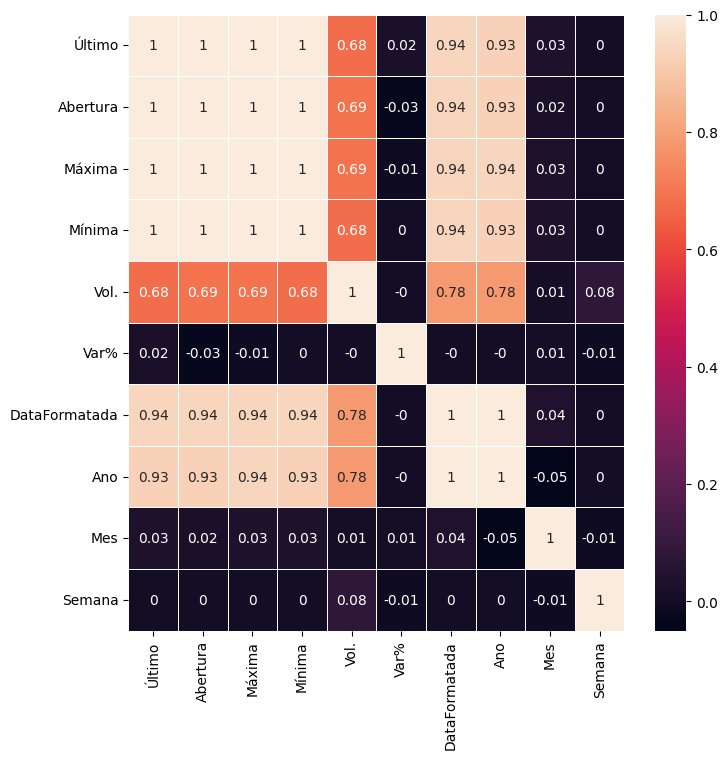

In [322]:
import seaborn as sns

correlation_matrix = df_ibov.corr().round(2)

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(data=correlation_matrix, annot=True, linewidths=.5, ax=ax)

### Pontos de fechamento ao longo dos anos

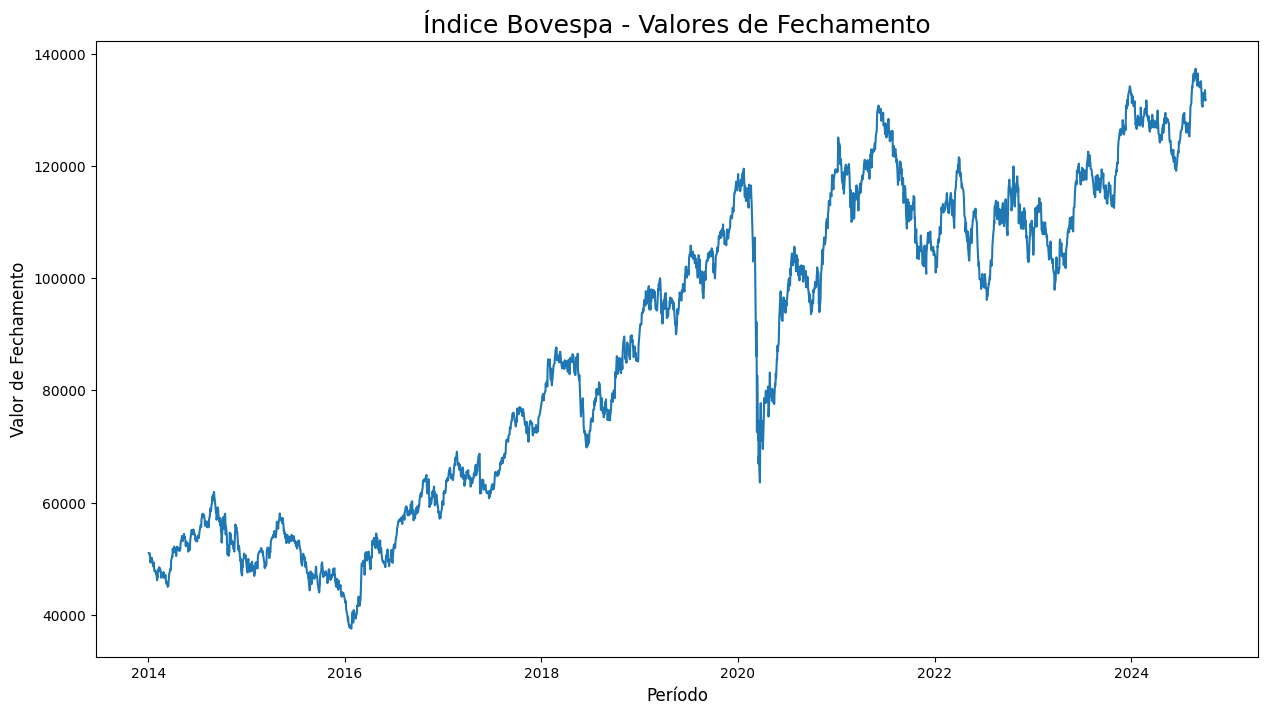

In [323]:
# plt.figure(figsize=(20, 5))
# plt.plot(df_ibov["DataFormatada"], df_ibov["Último"], label="Preço de Fechamento")
# plt.title("Pontos de Fechamento Ibovespa últimos 10 anos")
# plt.xlabel("DataFormatada")
# plt.ylabel("Pontos de Fechamento")
# plt.legend()
# plt.show()

plt.figure(figsize = (15,8))

plt.plot(df_ibov.index, df_ibov.Último)
plt.title('Índice Bovespa - Valores de Fechamento', fontsize=18)
plt.xlabel('Período', fontsize=12)
plt.ylabel('Valor de Fechamento', fontsize=12)

plt.show()

In [329]:
pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 21.9 MB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.


<Axes: xlabel='Data'>

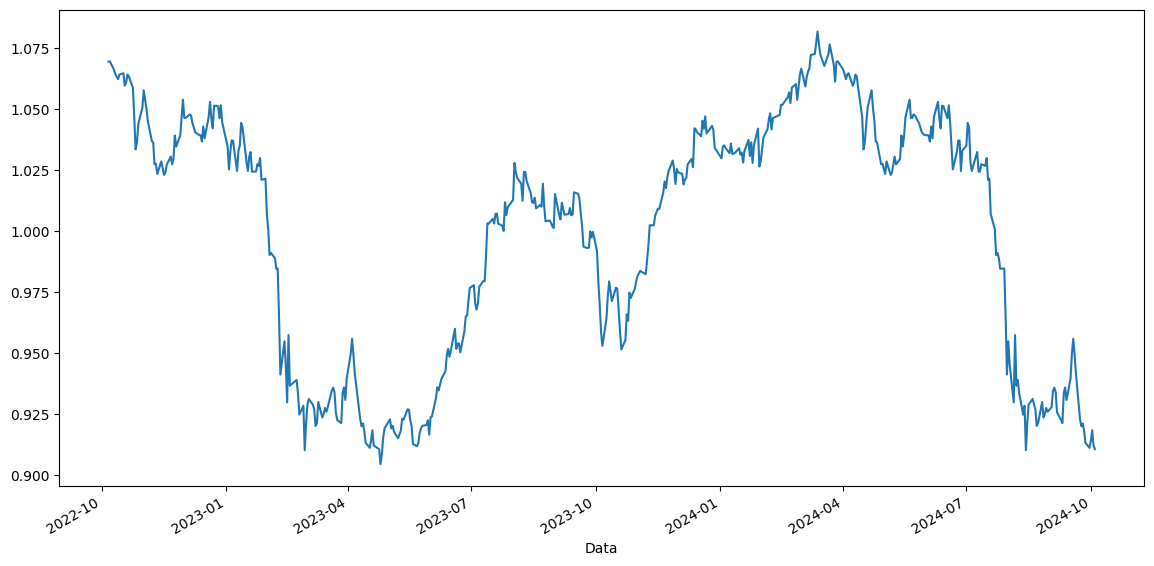

In [331]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_ibov["Último"], model="multiplicative", period=365)
result.seasonal.iloc[:500].plot(figsize=(14, 7))

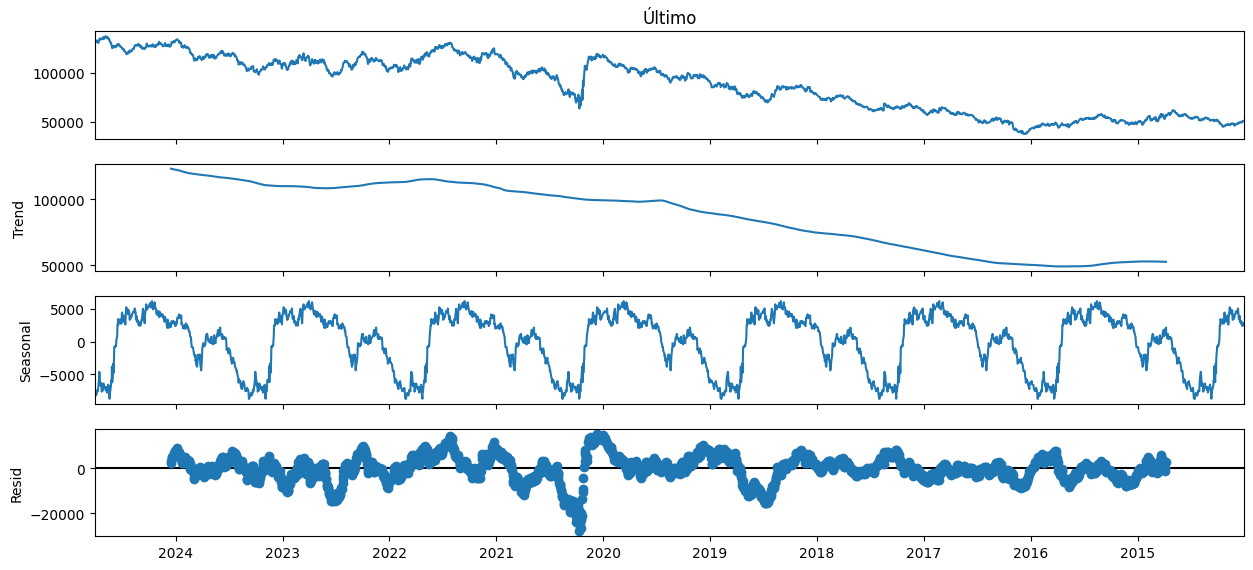

In [332]:
result = seasonal_decompose(df_ibov["Último"], model="additive", period=365)
fig = result.plot()
fig.set_size_inches(14, 6)